In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os, sys
from pathlib import Path
from pandarallel import pandarallel

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

########   Initialize and setup pandas methods   ########
pandarallel.initialize(nb_workers=os.cpu_count()-1, progress_bar=False, 
                       verbose=2, use_memory_fs=False) 
os.environ['JOBLIB_TEMP_FOLDER'] = '/tmp' 

try: 
    __file__
    sys.path.append(os.path.join(os.path.dirname('__file__')))
except NameError:
    Path().resolve()
    sys.path.append(os.path.join(Path().resolve(), '../../'))

from libs.scoring import Scoring
import pickle

INFO: Pandarallel will run on 3 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [6]:
start = 1
end = 10
bootstrap = int(end) - int(start) + 1

print(f"start: {start}, end: {end}, bootstrap: {bootstrap}")
for i, set_num in enumerate(range(start, end + 1)):
    print(f"index: {i}, set_num: {set_num}")

start: 1, end: 10, bootstrap: 10
index: 0, set_num: 1
index: 1, set_num: 2
index: 2, set_num: 3
index: 3, set_num: 4
index: 4, set_num: 5
index: 5, set_num: 6
index: 6, set_num: 7
index: 7, set_num: 8
index: 8, set_num: 9
index: 9, set_num: 10


In [2]:
def specificity_sensitivity_plotly(data):
    thresholds = np.arange(0, 11, 1)
    results = []

    for threshold in thresholds:
        tp = data[(data['PriorityScore'] >= threshold) & (data['LABEL'] == 1)].shape[0]
        fn = data[(data['PriorityScore'] < threshold) & (data['LABEL'] == 1)].shape[0]
        tn = data[(data['PriorityScore'] < threshold) & (data['LABEL'] == 0)].shape[0]
        fp = data[(data['PriorityScore'] >= threshold) & (data['LABEL'] == 0)].shape[0]
        specificity = tn / (tn + fp) if (tn + fp) else 0
        sensitivity = tp / (tp + fn) if (tp + fn) else 0
        # print(f"Threshold: {threshold}, TP: {tp}, FN: {fn}, TN: {tn}, FP: {fp}")
        # print(f"Threshold: {threshold}, Specificity: {specificity:.6f}, Sensitivity: {sensitivity:.6f}")
        results.append({'Threshold': threshold, 'Metric': 'Specificity', 'Value': specificity})
        results.append({'Threshold': threshold, 'Metric': 'Sensitivity', 'Value': sensitivity})

    results_df = pd.DataFrame(results)
    return results_df

def plot_sensitivity_specificity_plotly(results_df):
    # Separate the dataframes for specificity and sensitivity
    specificity_df = results_df[results_df['Metric'] == 'Specificity']
    sensitivity_df = results_df[results_df['Metric'] == 'Sensitivity']

    # Plotly Graph Objectsを使用してプロット
    fig = go.Figure()

    # 特異性
    fig.add_trace(go.Scatter(
        x=specificity_df['Threshold'],
        y=specificity_df['Value'],
        marker=dict(color='#665990'),
        mode='lines+markers',
        name='Specificity',
        text=[f'Threshold: {th}, Specificity: {val:.3f}' for th, val in zip(specificity_df['Threshold'], specificity_df['Value'])],
        hoverinfo='text'
    ))
    
    # 感度
    fig.add_trace(go.Scatter(
        x=sensitivity_df['Threshold'],
        y=sensitivity_df['Value'],
        marker=dict(color='#F8ACAC'),
        mode='lines+markers',
        name='Sensitivity',
        text=[f'Threshold: {th}, Sensitivity: {val:.3f}' for th, val in zip(sensitivity_df['Threshold'], sensitivity_df['Value'])],
        hoverinfo='text'
    ))

    # Y軸のフォーマット設定
    fig.update_yaxes(tickformat=".1f")

    # グラフのレイアウト設定
    fig.update_layout(title='Sensitivity and Specificity for each threshold',
                      xaxis_title='Threshold',
                      yaxis_title='Sensitivity/Specificity',
                      plot_bgcolor='rgba(243, 243, 243, 1)',
                      paper_bgcolor='rgba(243, 243, 243, 0)',
                      font=dict(family="Arial, sans-serif", size=12, color="black"),
                      legend=dict(y=0.075, x=0.75, xanchor='right', yanchor='bottom', 
                              bgcolor='rgba(243, 243, 243, 1)',
                              font=dict(family="Arial, sans-serif", size=12, color="black"))
                              )

    # グラフサイズの調整
    fig.update_layout(width=600, height=600)
    fig.write_html("sensitivity_specificity_plot.html")

    # fig.show()
    return fig

def plot_sensitivity_specificity_plotly_without_legened(results_df):
    # Separate the dataframes for specificity and sensitivity
    specificity_df = results_df[results_df['Metric'] == 'Specificity']
    sensitivity_df = results_df[results_df['Metric'] == 'Sensitivity']

    # Plotly Graph Objectsを使用してプロット
    fig = go.Figure()

    # 特異性
    fig.add_trace(go.Scatter(
        x=specificity_df['Threshold'],
        y=specificity_df['Value'],
        marker=dict(color='green'),
        mode='lines+markers',
        name='Specificity',
        text=[f'Threshold: {th}, Specificity: {val:.8f}' for th, val in zip(specificity_df['Threshold'], specificity_df['Value'])],
        hoverinfo='text',
        showlegend=False 
    ))
    
    # 感度
    fig.add_trace(go.Scatter(
        x=sensitivity_df['Threshold'],
        y=sensitivity_df['Value'],
        marker=dict(color='orange'),
        mode='lines+markers',
        name='Sensitivity',
        text=[f'Threshold: {th}, Sensitivity: {val:.8f}' for th, val in zip(sensitivity_df['Threshold'], sensitivity_df['Value'])],
        hoverinfo='text',
        showlegend=False
    ))

    # Y軸のフォーマット設定
    fig.update_yaxes(tickformat=".1f")

    # グラフのレイアウト設定
    fig.update_layout(title='Sensitivity and Specificity for each threshold',
                      xaxis_title='Threshold',
                      yaxis_title='Sensitivity/Specificity',
                      plot_bgcolor='rgba(243, 243, 243, 1)',
                      paper_bgcolor='rgba(243, 243, 243, 0)',
                      font=dict(family="Arial, sans-serif", size=12, color="black"),
                      legend=dict(y=0.075, x=0.75, xanchor='right', yanchor='bottom', 
                              bgcolor='rgba(243, 243, 243, 1)',
                              font=dict(family="Arial, sans-serif", size=12, color="black"))
                              )

    # グラフサイズの調整
    fig.update_layout(width=600, height=600)
    fig.write_html("sensitivity_specificity_plot.html")

    # fig.show()
    return fig


# Code below is adapted from Netflix's VMAF and BesenbacherLab's ROC-utils
# https://github.com/Netflix/vmaf/
# https://github.com/BesenbacherLab/ROC-utils
# Modifications: np.float -> np.float64

def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float64)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float64)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float64)
    ty = np.empty([k, n], dtype=np.float64)
    tz = np.empty([k, m + n], dtype=np.float64)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count


def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


def delong_roc_test(ground_truth, predictions_one, predictions_two):
    """
    Computes log(p-value) for hypothesis that two ROC AUCs are different
    Args:
       ground_truth: np.array of 0 and 1
       predictions_one: predictions of the first model,
          np.array of floats of the probability of being class 1
       predictions_two: predictions of the second model,
          np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    return calc_pvalue(aucs, delongcov)

# Calculate AUC confidence interval (95%)
def compute_auc_confidence_interval(auc, var, confidence_level=0.95):
    alpha = 1 - confidence_level
    z_score = scipy.stats.norm.ppf(1 - alpha/2)  # 2-tailed z score
    se = np.sqrt(var)  # Calculate SE from variance
    lower_bound = auc - z_score * se
    upper_bound = auc + z_score * se
    return lower_bound, upper_bound


def scoaring_calibraiton(ths: dict, tp_pkl: str, tn_pkl: str):

    ths_scores = {'clinvar_same_pos': ths['s1'],
             'clinvar_same_motif': ths['s2'],
             'clinvar_else': ths['s3'],
             'non_canon_splai_lte_0.1_outside': ths['s4'],    
             'non_canon_splai_lte_0.1_other': ths['s5'],
             'non_canon_splai_bet_0.1_0.2': ths['s6'],
             'non_canon_splai_gte_0.2': ths['s7'],
             'canon_strong': ths['s8'], 
             'canon_moderate': ths['s9'], 
             'frameshift_nmd_eloF': ths['s10'], 
             'frameshift_nmd_not_eloF': ths['s11'],
             'canon_splai_lte_0.1': ths['s12'],
             'canon_splai_bet_0.1_0.2': ths['s13'],
             'canon_splai_gte_0.2': ths['s14']}

    scoring = Scoring(ths=ths_scores)
    # df = pd.read_pickle('../TP/tp_prescore_train.pkl')
    df = pd.read_pickle(tp_pkl)
    df['insilico_screening'] = df.parallel_apply(scoring.insilico_screening, axis=1)
    df['clinvar_screening'] = df.parallel_apply(scoring.clinvar_screening, axis=1)
    tp = scoring.calc_priority_score(df)

    # df = pd.read_pickle('../TN/tn_prescore_train.pkl')
    df = pd.read_pickle(tn_pkl)
    df['insilico_screening'] = df.parallel_apply(scoring.insilico_screening, axis=1)
    df['clinvar_screening'] = df.parallel_apply(scoring.clinvar_screening, axis=1)
    tn = scoring.calc_priority_score(df)

    # Exclude Y chromosome
    tn = tn[tn['CHROM'] != 'Y']
    # print(f"Samples in TP: {tp.shape[0]}  Samples in TN: {tn.shape[0]}")

    tp.loc[:,'LABEL'] = 1
    tn.loc[:,'LABEL'] = 0
    tp = tp[['LABEL', 'PriorityScore', 'maxsplai']]
    tn = tn[['LABEL', 'PriorityScore', 'maxsplai']]

    # Combine tp and tn
    data = pd.concat([tp, tn], ignore_index=True)
    # results_df = specificity_sensitivity_plotly(data)
    # plot_sensitivity_specificity_plotly(results_df)

    ground_truth = np.array(data['LABEL'])
    predictions_fw = np.array(data['PriorityScore'])
    # predictions_sp = np.array(data['maxsplai'])

    auc1, var1 = delong_roc_variance(ground_truth, predictions_fw)
    cilower1, ciupper1 = compute_auc_confidence_interval(auc1, var1)
    # auc2, var2 = delong_roc_variance(ground_truth, predictions_sp)
    # cilower2, ciupper2 = compute_auc_confidence_interval(auc2, var2)

    # p_value_log = delong_roc_test(ground_truth, predictions_fw, predictions_sp)

    # print(f"AUC - Framework (95%CI): {auc1:.3f} [{cilower1:.4f}-{ciupper1:.4f}]")
    # print(f"AUC - SpliceAI (95%CI) : {auc2:.3f} [{cilower2:.4f}-{ciupper2:.4f}]")
    # print(f"p-value (DeLong Test)  : {10**p_value_log[0][0]:.2e}")

    return f"{auc1:.10f} [{cilower1:.12f}-{ciupper1:.12f}]"


In [3]:
from ortools.sat.python import cp_model

class SolutionCollector(cp_model.CpSolverSolutionCallback):
    def __init__(self, variables):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.__variables = variables
        self.__solutions = []

    def OnSolutionCallback(self):
        solution = {v.Name(): self.Value(v) for v in self.__variables}
        self.__solutions.append(solution)

    def GetAllSolutions(self):
        return self.__solutions

def find_all_solutions():
    # モデルを初期化
    model = cp_model.CpModel()

    # 変数の定義
    s = {i: model.NewIntVar(-10, 10, f's{i}') for i in range(1, 15)}

    # 制約の追加
    model.Add(s[3] == 0)                    #
    model.Add(s[1] + s[10] + s[14] == 9)    #
    model.Add(s[3] + s[11] + s[12] == 0)    #
    # model.Add(s[1] + s[7] < 9)
    # model.Add(s[10] >= 3)
    # model.Add(s[10] <= 7)
    
    # Knowledge-based
    # Absolutes
    model.Add(s[2] >= 1)                #
    model.Add(s[1] - s[2] > 0)          #   
    
    # SpliceAI limitation
    # Absolutes
    model.Add(s[4] < 0)                 #
    model.Add(s[5] <= 0)                #
    model.Add(s[6] >= 0)                #
    # model.Add(s[7] >= 1)
    model.Add(s[12] < 0)                #
    model.Add(s[13] <= 0)               #
    model.Add(s[14] >= 0)               #
    # Order
    model.Add(s[5] - s[4] > 0)          #
    model.Add(s[6] - s[5] > 0)          #
    model.Add(s[7] - s[6] > 0)          #
    model.Add(s[13] - s[12] > 0)        #
    model.Add(s[14] - s[13] > 0)        #
    model.Add(s[4] >= s[12])            #

    # under limit
    # model.Add(s[1] + s[10] + s[12] >= 0)
    # model.Add(s[4] <= s[10] + s[12])

    # Absolutes
    model.Add(s[11] >= 0)               #
    # Score order
    model.Add(s[9] >= s[7])             #
    model.Add(s[8] - s[9] > 0)          #
    model.Add(s[10] - s[8] > 0)         #
    # model.Add(s[9] - s[11] > 0)         #
    model.Add(s[9] - s[11] >= 0)         #


    # ソルバの設定と解の探索
    solver = cp_model.CpSolver()
    solution_collector = SolutionCollector([s[i] for i in range(1, 15)])
    solver.SearchForAllSolutions(model, solution_collector)
    
    # 全ての解を返す
    return solution_collector.GetAllSolutions()

# 解の計算
all_solutions = find_all_solutions()
print(f'Total solutions found: {len(all_solutions)}')
for index, solution in enumerate(all_solutions):
    print(f'Solution {index + 1}: {solution}')


Total solutions found: 4850
Solution 1: {'s1': 2, 's2': 1, 's3': 0, 's4': -1, 's5': 0, 's6': 1, 's7': 2, 's8': 3, 's9': 2, 's10': 6, 's11': 1, 's12': -1, 's13': 0, 's14': 1}
Solution 2: {'s1': 2, 's2': 1, 's3': 0, 's4': -1, 's5': 0, 's6': 1, 's7': 2, 's8': 3, 's9': 2, 's10': 6, 's11': 2, 's12': -2, 's13': 0, 's14': 1}
Solution 3: {'s1': 2, 's2': 1, 's3': 0, 's4': -2, 's5': 0, 's6': 1, 's7': 2, 's8': 3, 's9': 2, 's10': 6, 's11': 2, 's12': -2, 's13': 0, 's14': 1}
Solution 4: {'s1': 2, 's2': 1, 's3': 0, 's4': -1, 's5': 0, 's6': 1, 's7': 2, 's8': 3, 's9': 2, 's10': 6, 's11': 2, 's12': -2, 's13': -1, 's14': 1}
Solution 5: {'s1': 2, 's2': 1, 's3': 0, 's4': -2, 's5': -1, 's6': 0, 's7': 2, 's8': 3, 's9': 2, 's10': 6, 's11': 2, 's12': -2, 's13': 0, 's14': 1}
Solution 6: {'s1': 2, 's2': 1, 's3': 0, 's4': -2, 's5': -1, 's6': 1, 's7': 2, 's8': 3, 's9': 2, 's10': 6, 's11': 2, 's12': -2, 's13': 0, 's14': 1}
Solution 7: {'s1': 2, 's2': 1, 's3': 0, 's4': -2, 's5': 0, 's6': 1, 's7': 2, 's8': 3, 's9': 2

In [21]:
all_solutions[1302]

{'s1': 2,
 's2': 1,
 's3': 0,
 's4': -3,
 's5': -2,
 's6': 1,
 's7': 2,
 's8': 6,
 's9': 5,
 's10': 7,
 's11': 3,
 's12': -3,
 's13': -1,
 's14': 0}

In [14]:
dfs2.to_csv('all_solutions_4850s2.tsv', sep='\t', index=False)

In [18]:
dfs2.loc[1694]

s1     2
s2     1
s3     0
s4    -4
s5    -3
s6     0
s7     1
s8     6
s9     5
s10    7
s11    5
s12   -5
s13   -2
s14    0
Name: 1694, dtype: int64

In [4]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
all_calibration = scoring_calibration

In [7]:
df_cal = pd.DataFrame(list(scoring_calibration.items()), columns=['Candidate', 'Score'])
#scoring_calibration

In [8]:
df_cal.to_csv('rsults_calibration_train.csv', index=False, sep='\t')

In [5]:
df_tp_all = pd.read_pickle('../TP/tp_prescore.pkl')
df_tn_all = pd.read_pickle('../TN/tn_prescore.pkl')

# Exclude Y chromosome
df_tn_all = df_tn_all[df_tn_all['CHROM'] != 'Y']
# print(f"Samples in TP: {tp.shape[0]}  Samples in TN: {tn.shape[0]}")

df_tp_all.loc[:,'LABEL'] = 1
df_tn_all.loc[:,'LABEL'] = 0


In [ ]:
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
import os

# Load overall data for TP and TN 
df_tp_all = pd.read_pickle('../TP/tp_prescore.pkl')
df_tn_all = pd.read_pickle('../TN/tn_prescore.pkl')

def process_bootstrap(i):
    results = {}
    # For TP
    tp_val = df_tp_all.sample(frac=0.9, random_state=i)
    tp_test = df_tp_all.drop(tp_val.index)
    tp_val.to_pickle(f'pkls/tp_val_{i}.pkl')
    tp_test.to_pickle(f'pkls/tp_test_{i}.pkl')
    
    # For TN
    tn_val = df_tn_all.sample(frac=0.9, random_state=i)
    tn_test = df_tn_all.drop(tn_val.index)
    tn_val.to_pickle(f'pkls/tn_val_{i}.pkl')
    tn_test.to_pickle(f'pkls/tn_test_{i}.pkl')

    scoring_calibration = {}
    for index, solution in enumerate(all_solutions):
        if index % 200 == 0:
            print(f'set {i}: Solution {index + 1}')
        else:
            pass
        scoring_calibration[f"Solution {index + 1}"] = scoaring_calibraiton(
            solution, f'pkls/tp_val_{i}.pkl', f'pkls/tn_val_{i}.pkl')

    # When completed eacj bootstrap, create a flag file
    with open(f'pkls/flag_bootstrap_{i}', 'w') as f:
        f.write('Done')
    
    results[i] = scoring_calibration
    return results

# Set number of bootstrap and parallel processing 
bootstrap = 100
all_results: dict = {}

with ProcessPoolExecutor() as executor:
    future_results = list(executor.map(process_bootstrap, range(1, bootstrap + 1)))
for result in future_results:
    all_results.update(result)

with open(f'pkls/Completed', 'w') as f:
    f.write("All processes are complete.")

# Save the all_results as pickle
with open('all_results.pkl', 'wb') as f:
    pickle.dump(all_results, f)


In [ ]:
/home/utsu/workspace/Github/dev/ValidationData/AUC/pkls/all_results.pkl

In [ ]:
with open('pkls/all_results.pkl', 'rb') as f:
    all_results_restored = pickle.load(f)

In [9]:
df = pd.DataFrame(columns=['Dataset', 'Candidate', 'Score'])
for set in all_results_restored.keys():
    buf_df = pd.DataFrame(
        list(all_results_restored[set].items()), columns=['Candidate', 'Score'])
    buf_df['Dataset'] = set
    df = pd.concat([df, buf_df], ignore_index=True)
    

In [11]:
df['auROC'] = df['Score'].str.split(' ', expand=True)[0].astype(float)
df['95%CI'] = df['Score'].str.split(' ', expand=True)[1]
df['CI_lower'] = df['95%CI'].str.extract(r'(\d\.\d*)').astype('float')
df['CI_upper'] = df['95%CI'].str.extract(r'((?<=-)\d\.\d*(?=]))').astype(float)
df.drop(['Score', '95%CI'], axis=1, inplace=True)
solutions = pd.DataFrame(all_solutions)
solutions_list = [f"Solution {i}" for i in range(1, 4851)]
patterns_sr = pd.Series(solutions_list, name='Solution')
solutions = pd.concat([patterns_sr, solutions], axis=1)
df = pd.merge(df, solutions, left_on='Candidate', right_on='Solution')
df.drop('Solution', axis=1, inplace=True)
df['SampleVariance'] = df.iloc[:, 5:20].var(axis=1, ddof=0)

In [17]:
ddf = df.groupby('Dataset')
maxdf = df.loc[ddf['auROC'].idxmax(),:]

In [27]:
bootstrap = 100
set_max = []
for i in range(1, bootstrap + 1):
    set_max.append(df.loc[(df['Dataset'] == i) & (df['auROC'] == maxdf.loc[maxdf['Dataset'] == i, 'auROC'].values[0]), :])


In [ ]:
with open('pkls/set_max_bkup.pkl', 'xb') as f:
    pickle.dump(set_max, f)

In [22]:
with open('pkls_1st/set_max.pkl', 'rb') as f:
    set_max = pickle.load(f)

In [7]:
bufsetmax = set_max 

In [9]:
bootstrap = 100
best = {}
for i in range(bootstrap):
    highest_variance = set_max[i].loc[set_max[i]['SampleVariance'].idxmax(), 'SampleVariance']
    # If other candidate has the same variance, add it to the 
    best[f'set {i + 1}'] = set_max[i].loc[set_max[i]['SampleVariance'] == highest_variance, 'Candidate'].values


In [23]:
set_max[0]

,Dataset,Candidate,auROC,CI_lower,CI_upper,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,SampleVariance
84,1,Solution 85,0.996099,0.995382,0.996816,2,1,0,-1,0,1,2,5,4,6,2,-2,0,1,4.678571
85,1,Solution 86,0.996099,0.995382,0.996816,2,1,0,-2,0,1,2,5,4,6,2,-2,0,1,5.102041
86,1,Solution 87,0.996099,0.995382,0.996816,2,1,0,-2,-1,1,2,5,4,6,2,-2,0,1,5.372449
1136,1,Solution 1137,0.996099,0.995382,0.996816,2,1,0,-1,0,1,2,6,5,7,3,-3,-1,0,7.530612
1240,1,Solution 1241,0.996099,0.995382,0.996816,2,1,0,-2,0,1,2,6,5,7,3,-3,-1,0,7.964286
1241,1,Solution 1242,0.996099,0.995382,0.996816,2,1,0,-3,0,1,2,6,5,7,3,-3,-1,0,8.530612
1557,1,Solution 1558,0.996099,0.995382,0.996816,2,1,0,-2,-1,1,2,6,5,7,3,-3,-1,0,8.244898
1615,1,Solution 1616,0.996099,0.995382,0.996816,2,1,0,-3,-1,1,2,6,5,7,3,-3,-1,0,8.801020
1695,1,Solution 1696,0.996099,0.995382,0.996816,2,1,0,-3,-2,1,2,6,5,7,3,-3,-1,0,9.204082


In [ ]:
bootstrap = 100

df_tp_all = pd.read_pickle('../TP/tp_prescore.pkl')
df_tn_all = pd.read_pickle('../TN/tn_prescore.pkl')
buf = 0.9955

# Sampling 10% of the data for validation and test sets. Generetae 10 sets
all_results = {}
for i in range(1, bootstrap + 1):
    tp_val = df_tp_all.sample(frac=0.9, random_state=i)
    tp_test = df_tp_all.drop(tp_val.index)
    tp_val.to_pickle(f'pkls/tp_val_{i}.pkl')
    tp_test.to_pickle(f'pkls/tp_test_{i}.pkl')
    tn_val = df_tn_all.sample(frac=0.9, random_state=i)
    tn_test = df_tn_all.drop(tn_val.index)
    tn_val.to_pickle(f'pkls/tn_val_{i}.pkl')
    tn_test.to_pickle(f'pkls/tn_test_{i}.pkl')

    scoring_calibration = {}
    for index, solution in enumerate(all_solutions):
        if index % 200 == 0:
            print(f'set {i}: Solution {index + 1}')
        else:
            pass
        scoring_calibration[f"Solution {index + 1}"] = scoaring_calibraiton(solution, f'pkls/tp_val_{i}.pkl', f'pkls/tn_val_{i}.pkl')
        if buf < float(scoring_calibration[f'Solution {index + 1}'].split(' ')[0]):
            buf = float(scoring_calibration[f'Solution {index + 1}'].split(' ')[0])
            print(f"set {i}: Solution {index + 1} -> {scoring_calibration[f'Solution {index + 1}']}")
        else:
            pass

    all_results[f"set {i}"] = scoring_calibration

    # Write a falg file into the pkls directory for progress check 
    with open(f'pkls/flag_bootstrap_{i}', 'w') as f:
        f.write('Done')


In [ ]:

# Save all_results object as pickle
import pickle
with open('pkls/all_results.pkl', 'wb') as f:
    pickle.dump(all_results, f)

# When completed in bootstrap section, make a flag file
with open('pkls/flag_bootstrap_all', 'w') as f:
    f.write('Completed')


In [92]:

# load all_results object from pickle
with open('pkls/all_results.pkl', 'rb') as f:
    all_results_restored = pickle.load(f)

df = pd.DataFrame(columns=['Dataset', 'Candidate', 'Score'])
for set in all_results_restored.keys():
    buf_df = pd.DataFrame(
        list(all_results_restored[set].items()), columns=['Candidate', 'Score'])
    buf_df['Dataset'] = set
    df = pd.concat([df, buf_df], ignore_index=True)

df['auROC'] = df['Score'].str.split(' ', expand=True)[0].astype(float)
df['95%CI'] = df['Score'].str.split(' ', expand=True)[1]
df['CI_lower'] = df['95%CI'].str.extract(r'(\d\.\d*)').astype('float')
df['CI_upper'] = df['95%CI'].str.extract(r'((?<=-)\d\.\d*(?=]))').astype(float)
df.drop(['Score', '95%CI'], axis=1, inplace=True)

solutions = pd.DataFrame(all_solutions)
solutions_list = [f"Solution {i}" for i in range(1, 4851)]
patterns_sr = pd.Series(solutions_list, name='Solution')
solutions = pd.concat([patterns_sr, solutions], axis=1)

# Merge the two dataframes
df = pd.merge(df, solutions, left_on='Candidate', right_on='Solution')
df.drop('Solution', axis=1, inplace=True)

# Calculate the sample variance of the scores for each solution
df['SampleVariance'] = df.iloc[:, 5:20].var(axis=1, ddof=0)

# Group by dataset and extract the best auROC
ddf = df.groupby('Dataset')
maxdf = df.loc[ddf['auROC'].idxmax(),:]

# Extract best auROC for each dataset
# Extract solutions for each dataset with the best auROC value defined above
# Store a dictionary
set_max = []
for i in range(1, bootstrap + 1):
    set_max.append(df.loc[(df['Dataset'] == f'set {i}') & (df['auROC'] == maxdf.loc[maxdf['Dataset'] == f'set {i}', 'auROC'].values[0]), :])

# Save set_max as pickle
with open('pkls/set_max.pkl', 'wb') as f:
    pickle.dump(set_max, f)

# Extract the solution No. with most highest sample variance from each set_max[i]. 
# The results put a dictionary with set number.
best = {}
for i in range(bootstrap):
    highest_variance = set_max[i].loc[set_max[i]['SampleVariance'].idxmax(), 'SampleVariance']
    # If other candidate has the same variance, add it to the 
    best[f'set {i + 1}'] = set_max[i].loc[set_max[i]['SampleVariance'] == highest_variance, 'Candidate'].values

# Save best as pickle
with open('pkls/best.pkl', 'wb') as f:
    pickle.dump(best, f)

# When completed, make a flag file
with open('pkls/flag_all', 'w') as f:
    f.write('completed')

EOFError: Ran out of input

,Solution,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14
1695,Solution 1696,2,1,0,-3,-2,1,2,6,5,7,3,-3,-1,0


In [256]:
# pickup the most highest sample variance solution for each dataset
# set 1
set1_max_sample_variance = set1_max[set1_max['Dataset'] == 'set 1']['SampleVariance'].idxmax()

In [8]:
all_results_df.to_csv('results_calibration_val.csv', index=False, sep='\t')

In [ ]:
for index, solution in enumerate(all_solutions):
	if index % 200 == 0:
		print(f'Solution {index + 1}')
	else:
		pass
	scoring_calibration[f"Solution {index + 1}"] = scoaring_calibraiton(solution, '../TN/tn_prescore.pkl', '../TP/tp_prescore.pkl')
	if buf <= float(scoring_calibration[f'Solution {index + 1}'].split(' ')[0]):
		buf = float(scoring_calibration[f'Solution {index + 1}'].split(' ')[0])
		print(f'Solution {index + 1}')
		print(scoring_calibration[f'Solution {index + 1}'])
	else:
		pass

In [ ]:

df = pd.read_pickle('../TP/tp_prescore.pkl')
df['insilico_screening'] = df.parallel_apply(scoring.insilico_screening, axis=1)
df['clinvar_screening'] = df.parallel_apply(scoring.clinvar_screening, axis=1)
tp = scoring.calc_priority_score(df)

df = pd.read_pickle('../TN/tn_prescore.pkl')
df['insilico_screening'] = df.parallel_apply(scoring.insilico_screening, axis=1)
df['clinvar_screening'] = df.parallel_apply(scoring.clinvar_screening, axis=1)
tn = scoring.calc_priority_score(df)
tn = tn[tn['CHROM'] != 'Y']

# Add label
tp.loc[:, 'LABEL'] = 1
tn.loc[:, 'LABEL'] = 0

# Extract the columns needed
tp = tp[['LABEL', 'PriorityScore', 'maxsplai']]
tn = tn[['LABEL', 'PriorityScore', 'maxsplai']]


##### STEP4. Comaprison with SpliceAI alone method

In [4]:
solutions

NameError: name 'solutions' is not defined

In [ ]:
solutions.loc[solutions['Solution'] == "Solution 1696"]

NameError: name 'solutions' is not defined

In [ ]:
thsdict = {'opti': {
    'clinvar_same_pos': 2,
    'clinvar_same_motif': 1,
    'clinvar_else': 0,
    'non_canon_splai_lte_0.1_outside': -3,
    'non_canon_splai_lte_0.1_other': -2,
    'non_canon_splai_bet_0.1_0.2': 1,
    'non_canon_splai_gte_0.2': 2,
    'canon_strong': 6, 
    'canon_moderate': 5, 
    'frameshift_nmd_eloF': 7, 
    'frameshift_nmd_not_eloF': 3,
    'canon_splai_lte_0.1': -3,
    'canon_splai_bet_0.1_0.2': -1,
    'canon_splai_gte_0.2': 0}
    }

ths = thsdict['opti']
scoring = Scoring(ths=ths)  # construct the scoring object with the best solution

In [ ]:
rocs_fw = []
rocs_sp = []

for i in range(1, 101):
    tp_test = f"/home/utsu/workspace/Github/dev/ValidationData/AUC/pkls/tp_test_{i}.pkl"
    tn_test = f"/home/utsu/workspace/Github/dev/ValidationData/AUC/pkls/tn_test_{i}.pkl"

    df = pd.read_pickle(tp_test)
    df['insilico_screening'] = df.parallel_apply(scoring.insilico_screening, axis=1)
    df['clinvar_screening'] = df.parallel_apply(scoring.clinvar_screening, axis=1)
    tp = scoring.calc_priority_score(df)

    df = pd.read_pickle(tn_test)
    df['insilico_screening'] = df.parallel_apply(scoring.insilico_screening, axis=1)
    df['clinvar_screening'] = df.parallel_apply(scoring.clinvar_screening, axis=1)
    tn = scoring.calc_priority_score(df)
    tn = tn[tn['CHROM'] != 'Y']

    # Add label
    tp.loc[:, 'LABEL'] = 1
    tn.loc[:, 'LABEL'] = 0
    # Extract the columns needed
    tp = tp[['LABEL', 'PriorityScore', 'maxsplai']]
    tn = tn[['LABEL', 'PriorityScore', 'maxsplai']]
    # Combine tp and tn and save
    data = pd.concat([tp, tn], ignore_index=True)

    # Plot the sensitivity and specificity for each threshold
    results_df = specificity_sensitivity_plotly(data)
    fig_opti = plot_sensitivity_specificity_plotly(results_df)
    # fig2 = plot_sensitivity_specificity_plotly_without_legened(results_df)
    # print(tp['PriorityScore'].isnull().sum(), tn['PriorityScore'].isnull().sum())

    ## DeLong test and AUC confidence interval
    ground_truth = np.array(data['LABEL'])
    predictions_fw = np.array(data['PriorityScore'])
    predictions_sp = np.array(data['maxsplai'])

    auc1, var1 = delong_roc_variance(ground_truth, predictions_fw)
    cilower1, ciupper1 = compute_auc_confidence_interval(auc1, var1)
    auc2, var2 = delong_roc_variance(ground_truth, predictions_sp)
    cilower2, ciupper2 = compute_auc_confidence_interval(auc2, var2)

    p_value_log = delong_roc_test(ground_truth, predictions_fw, predictions_sp)

    # print(f"AUC - Framework (95%CI): {auc1:.3f} [{cilower1:.4f}-{ciupper1:.4f}]")
    # print(f"AUC - SpliceAI (95%CI) : {auc2:.3f} [{cilower2:.4f}-{ciupper2:.4f}]")
    # print(f"p-value (DeLong Test)  : {10**p_value_log[0][0]:.2e}")
    # data.to_csv(f"roc_rawdata/data_{i}.tsv", index=False, sep='\t')
    rocs_fw.append(auc1)
    rocs_sp.append(auc2)



Data size: 100
Shapiro-Wilk test statistic: 0.993469081123173
p-value: 0.9146784881921315
差分データは正規分布に従います。
Kolmogorov-Smirnov test statistic: 0.4989861045325141
p-value: 1.5286064544578558e-23
Anderson-Darling test statistic: 0.20905418473263637
At significance level 15.0, the data is normal.
At significance level 10.0, the data is normal.
At significance level 5.0, the data is normal.
At significance level 2.5, the data is normal.
At significance level 1.0, the data is normal.


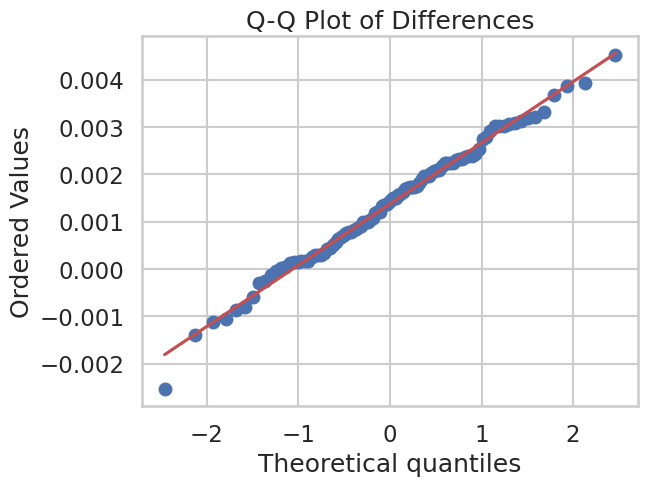

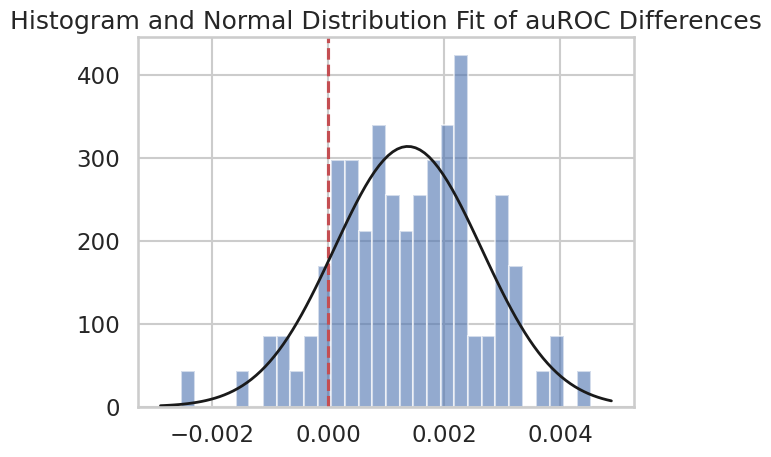

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, anderson
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import roc_auc_score
from joblib import Parallel, delayed


# 差分の計算
diffs = np.array(rocs_fw) - np.array(rocs_sp)

# Print data size
print(f"Data size: {len(diffs)}")

# シャピロ・ウィルク検定
stat, p_value = shapiro(diffs)
print(f"Shapiro-Wilk test statistic: {stat}")
print(f"p-value: {p_value}")
if p_value > 0.05:
    print("差分データは正規分布に従います。")
else:
    print("差分データは正規分布に従いません。")

# Kolmogorov-Smirnov test
stat, p_value = stats.kstest(diffs, 'norm')
print(f"Kolmogorov-Smirnov test statistic: {stat}")
print(f"p-value: {p_value}")

# Anderson-Darling test
from scipy.stats import anderson

result = anderson(diffs)
print(f"Anderson-Darling test statistic: {result.statistic}")
for i, (cv, sig_lvl) in enumerate(zip(result.critical_values, result.significance_level)):
    if result.statistic < cv:
        print(f"At significance level {sig_lvl}, the data is normal.")
    else:
        print(f"At significance level {sig_lvl}, the data is not normal.")


# The plots below with seaborn style colors
# Q-Q plot with seaborn
# Using color palette pastel
import seaborn as sns

sns.set_style('whitegrid')
sns.set_palette('gray')
sns.set_context('talk')
stats.probplot(diffs, dist="norm", plot=plt)
plt.title('Q-Q Plot of Differences')
plt.show()

# Histogram
plt.hist(diffs, bins=30, density=True, alpha=0.6, color='b')

# Plot the normal distribution curve with pastel colors
mu, std = np.mean(diffs), np.std(diffs)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
# Add 0 line to the plot
plt.axvline(0, color='r', linestyle='--')
plt.plot(x, p, 'k', linewidth=2)
plt.title('Histogram and Normal Distribution Fit of auROC Differences')
plt.show()

# import seaborn as sns
# sns.set()
# sns.set_style('whitegrid')
# sns.set_palette('gray')
# sns.set_context('talk')
# stats.probplot(diffs, dist="norm", plot=plt)
# plt.title('Q-Q Plot of Differences')
# plt.show()

# # Histogram
# plt.hist(diffs, bins=30, density=True, alpha=0.6, color='g')

# # 正規分布のカーブをプロット
# mu, std = np.mean(diffs), np.std(diffs)
# xmin, xmax = plt.xlim()
# x = np.linspace(xmin, xmax, 100)
# p = stats.norm.pdf(x, mu, std)
# plt.plot(x, p, 'k', linewidth=2)
# plt.title('Histogram and Normal Distribution Fit of Differences')
# plt.show()

t-statistic: 10.740769332206197
p-value: 2.6660169228773465e-18
FWとSPの性能に統計的に有意な差があります。


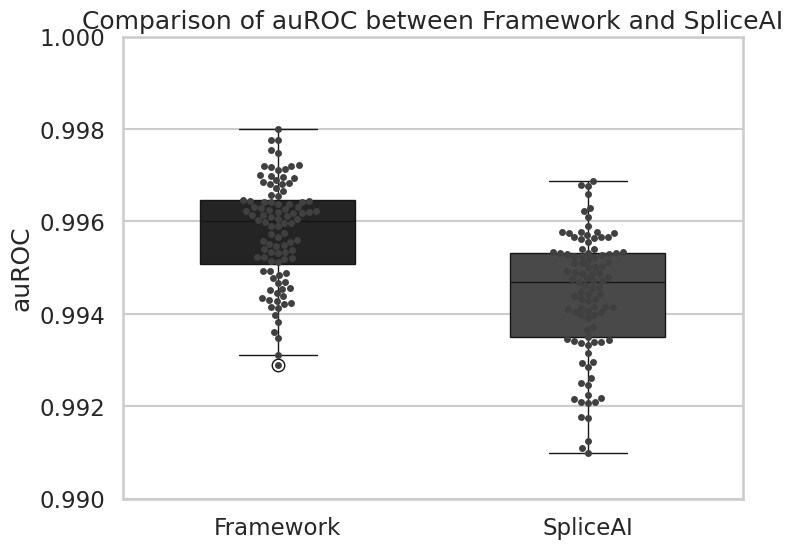

In [ ]:
from scipy.stats import ttest_rel

# paired t-testを実行
t_stat, p_value = ttest_rel(rocs_fw, rocs_sp)

print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("FWとSPの性能に統計的に有意な差があります。")
else:
    print("FWとSPの性能に統計的に有意な差はありません。")

# plot comparison of auROC with boxplot rocs_fw vs. rocs_sp
# With ggplot style
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
sns.set_palette('gray')
sns.set_context('talk')
plt.figure(figsize=(8, 6))
sns.boxplot(data=[rocs_fw, rocs_sp], width=0.5)
plt.xticks([0, 1], ['Framework', 'SpliceAI'])

# Add beeswarm plot
sns.swarmplot(data=[rocs_fw, rocs_sp], color=".25")


# Edit y-axis 0.99 to 1
plt.ylim(0.99, 1)

plt.ylabel('auROC')
plt.title('Comparison of auROC between Framework and SpliceAI')
plt.show()


In [ ]:
# Compare the performance of the two models
# Confusion matrix
th_2, th_3 = 2, 3
th_02, th_05, th_08 = 0.2, 0.5, 0.8
thresholds_fw = [th_2, th_3]
thresholds_spl = [th_02, th_05, th_08]

def calculate_performance_metrics_fw(data, threshold):
    data['Prediction'] = data['PriorityScore'] >= threshold
    tn, fp, fn, tp = confusion_matrix(data['LABEL'], data['Prediction']).ravel()
    specificity = tn / (tn + fp) if (tn + fp) else 0
    sensitivity = tp / (tp + fn) if (tp + fn) else 0
    accuracy = accuracy_score(data['LABEL'], data['Prediction'])
    precision = precision_score(data['LABEL'], data['Prediction'])
    f1 = f1_score(data['LABEL'], data['Prediction'])
    return specificity, sensitivity, accuracy, precision, f1

def calculate_performance_metrics_spl(data, threshold):
    data['Prediction'] = data['maxsplai'] >= threshold
    tn, fp, fn, tp = confusion_matrix(data['LABEL'], data['Prediction']).ravel()
    specificity = tn / (tn + fp) if (tn + fp) else 0
    sensitivity = tp / (tp + fn) if (tp + fn) else 0
    accuracy = accuracy_score(data['LABEL'], data['Prediction'])
    precision = precision_score(data['LABEL'], data['Prediction'])
    f1 = f1_score(data['LABEL'], data['Prediction'])
    return specificity, sensitivity, accuracy, precision, f1

def _genretate_data_from_pkls(pkls: list):
    tp_test = pkls[0]
    tn_test = pkls[1]

    df = pd.read_pickle(tp_test)
    df['insilico_screening'] = df.parallel_apply(scoring.insilico_screening, axis=1)
    df['clinvar_screening'] = df.parallel_apply(scoring.clinvar_screening, axis=1)
    tp = scoring.calc_priority_score(df)

    df = pd.read_pickle(tn_test)
    df['insilico_screening'] = df.parallel_apply(scoring.insilico_screening, axis=1)
    df['clinvar_screening'] = df.parallel_apply(scoring.clinvar_screening, axis=1)
    tn = scoring.calc_priority_score(df)
    tn = tn[tn['CHROM'] != 'Y']

    # Add label
    tp.loc[:, 'LABEL'] = 1
    tn.loc[:, 'LABEL'] = 0
    # Extract the columns needed
    tp = tp[['LABEL', 'PriorityScore', 'maxsplai']]
    tn = tn[['LABEL', 'PriorityScore', 'maxsplai']]

    return pd.concat([tp, tn], ignore_index=True)

# 1-100 bootstrap data
all_bootstrap_metrics = {}
for i in range(1, 101):
    tp_test = f"/home/utsu/workspace/Github/dev/ValidationData/AUC/pkls/tp_test_{i}.pkl"
    tn_test = f"/home/utsu/workspace/Github/dev/ValidationData/AUC/pkls/tn_test_{i}.pkl"
    data = _genretate_data_from_pkls([tp_test, tn_test])

    performance_metrics = []
    for threshold in thresholds_fw:
        specificity, sensitivity, accuracy, precision, f1 = calculate_performance_metrics_fw(data, threshold)
        performance_metrics.append({'Threshold': threshold, 'Specificity': specificity, 'Sensitivity': sensitivity, 'Accuracy': accuracy, 'Precision': precision, 'F1': f1})

    for threshold in thresholds_spl:
        specificity, sensitivity, accuracy, precision, f1 = calculate_performance_metrics_spl(data, threshold)
        performance_metrics.append({'Threshold': threshold, 'Specificity': specificity, 'Sensitivity': sensitivity, 'Accuracy': accuracy, 'Precision': precision, 'F1': f1})

    all_bootstrap_metrics[f"set {i}"] = performance_metrics


In [ ]:
def calculate_mean_and_se(all_bootstrap_metrics, thresholds_fw, thresholds_spl):
    metrics_summary = {'Threshold': [], 'Specificity_mean': [], 'Specificity_se': [], 'Sensitivity_mean': [], 'Sensitivity_se': [], 'Accuracy_mean': [], 'Accuracy_se': [], 'Precision_mean': [], 'Precision_se': [], 'F1_mean': [], 'F1_se': []}
    
    for threshold in thresholds_fw + thresholds_spl:
        specificity = []
        sensitivity = []
        accuracy = []
        precision = []
        f1 = []
        for set_metrics in all_bootstrap_metrics.values():
            for metric in set_metrics:
                if metric['Threshold'] == threshold:
                    specificity.append(metric['Specificity'])
                    sensitivity.append(metric['Sensitivity'])
                    accuracy.append(metric['Accuracy'])
                    precision.append(metric['Precision'])
                    f1.append(metric['F1'])
        
        metrics_summary['Threshold'].append(threshold)
        metrics_summary['Specificity_mean'].append(np.mean(specificity))
        metrics_summary['Specificity_se'].append(np.std(specificity) / np.sqrt(len(specificity)))
        metrics_summary['Sensitivity_mean'].append(np.mean(sensitivity))
        metrics_summary['Sensitivity_se'].append(np.std(sensitivity) / np.sqrt(len(sensitivity)))
        metrics_summary['Accuracy_mean'].append(np.mean(accuracy))
        metrics_summary['Accuracy_se'].append(np.std(accuracy) / np.sqrt(len(accuracy)))
        metrics_summary['Precision_mean'].append(np.mean(precision))
        metrics_summary['Precision_se'].append(np.std(precision) / np.sqrt(len(precision)))
        metrics_summary['F1_mean'].append(np.mean(f1))
        metrics_summary['F1_se'].append(np.std(f1) / np.sqrt(len(f1)))
    
    return pd.DataFrame(metrics_summary)

metrics_summary_df = calculate_mean_and_se(all_bootstrap_metrics, thresholds_fw, thresholds_spl)

columns = ['Category', 'Specificity', 'Specificity_se', 'Sensitivity',
           'Sensitivity_se', 'Accuracy', 'Accuracy_se', 'Precision', 'Precision_se', 'F1', 'F1_se']
metrics_summary_df.columns = columns

metrics_summary_df.replace(
    {'Category': {
        2.0: 'Framework (2)<br> High sensitivity', 
        3.0: 'Framework (3)<br> High specificity', 
        0.2: 'SpliceAI (0.2)<br> High sensitivity', 
        0.5: 'SpliceAI (0.5)<br> Recommended', 
        0.8: 'SpliceAI (0.8)<br> High precision'
        }}, inplace=True)



In [ ]:
metrics_summary_df

,Category,Specificity,Specificity_se,Sensitivity,Sensitivity_se,Accuracy,Accuracy_se,Precision,Precision_se,F1,F1_se
0,Framework (2)<br> High sensitivity,0.970356,0.000233,0.986266,0.000319,0.973219,0.000199,0.879614,0.000832,0.929869,0.000492
1,Framework (3)<br> High specificity,0.998562,0.000054,0.921145,0.000794,0.984630,0.000156,0.992938,0.000266,0.955678,0.000466
2,SpliceAI (0.2)<br> High sensitivity,0.972806,0.000226,0.974870,0.000440,0.973177,0.000199,0.887301,0.000831,0.929002,0.000500
3,SpliceAI (0.5)<br> Recommended,0.995636,0.000088,0.927786,0.000743,0.983426,0.000158,0.979031,0.000418,0.952703,0.000464
4,SpliceAI (0.8)<br> High precision,0.998758,0.000048,0.807064,0.001174,0.964261,0.000212,0.993045,0.000268,0.890399,0.000719


In [ ]:
colors = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3']

fig = go.Figure()

# Add traces with ggplot2 style with err bars from se data
fig.add_trace(go.Bar(
    x=metrics_summary_df['Category'], y=metrics_summary_df['Specificity'], 
    name='Specificity', marker_color=colors[0]))
fig.add_trace(go.Bar(
    x=metrics_summary_df['Category'], y=metrics_summary_df['Sensitivity'], 
    name='Sensitivity', marker_color=colors[2]))
# fig.add_trace(go.Bar(x=metrics_summary_df['Category'], y=metrics_summary_df['Accuracy'], name='Accuracy', marker_color=colors[2]))
fig.add_trace(go.Bar(
    x=metrics_summary_df['Category'], y=metrics_summary_df['Precision'], 
    name='Precision', marker_color=colors[3]))
fig.add_trace(go.Bar(
    x=metrics_summary_df['Category'], y=metrics_summary_df['F1'], 
    name='F-score', marker_color=colors[4]))

# Add titles and labels with ggplot2 style using bar plot
fig.update_layout(title='Performance Metrics Comparison',
                  xaxis_title='Methods (cutoff)',
                  yaxis_title='Value',
                  legend_title='Performance Metrics',
                  plot_bgcolor='rgba(243, 243, 243, 1)',
                  paper_bgcolor='rgba(243, 243, 243, 0)',
                  legend=dict(y=0.075, x=0.95, xanchor='right', yanchor='bottom', 
                              bgcolor='rgba(255, 255, 255, 0.8)',
                              bordercolor='rgba(0, 0, 0, 0)',
                              font=dict(family="Arial, sans-serif", size=12, color="black")),
                  margin=dict(l=40, r=40, t=40, b=40)
                  )


fig.update_layout(barmode='group')
fig.update_xaxes(categoryorder='total ascending')
size_const: int = 180
fig.update_layout(width=4*size_const, height=3*size_const)

fig.update_xaxes(categoryorder='array', 
                 categoryarray=['FW_3', 'FW_4', 'SPL_0.2', 'SPL_0.5', 'SPL_0.8'])
fig.write_html("performance-metrics.html")

# Show figure
fig.show()

In [ ]:

performance_metrics_df = pd.DataFrame(performance_metrics)
columns = ['Category', 'Specificity', 'Sensitivity', 'Accuracy', 'Precision', 'F1']
performance_metrics_df.columns = columns
performance_metrics_df.replace(
    {'Category': {
        2.0: 'Framework (2)<br> High sensitivity', 
        3.0: 'Framework (3)<br> High specificity', 
        0.2: 'SpliceAI (0.2)<br> High sensitivity', 
        0.5: 'SpliceAI (0.5)<br> Recommended', 
        0.8: 'SpliceAI (0.8)<br> High precision'
        }}, inplace=True)

# print(performance_metrics_df)

colors = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3']

fig = go.Figure()

# Add traces with ggplot2 style
fig.add_trace(go.Bar(x=performance_metrics_df['Category'], y=performance_metrics_df['Specificity'], name='Specificity', marker_color=colors[0]))
fig.add_trace(go.Bar(x=performance_metrics_df['Category'], y=performance_metrics_df['Sensitivity'], name='Sensitivity', marker_color=colors[2]))
# fig.add_trace(go.Bar(x=performance_metrics_df['Category'], y=performance_metrics_df['Accuracy'], name='Accuracy', marker_color=colors[2]))
fig.add_trace(go.Bar(x=performance_metrics_df['Category'], y=performance_metrics_df['Precision'], name='Precision', marker_color=colors[3]))
fig.add_trace(go.Bar(x=performance_metrics_df['Category'], y=performance_metrics_df['F1'], name='F-score', marker_color=colors[4]))

# Add titles and labels with ggplot2 style using bar plot
fig.update_layout(title='Performance Metrics Comparison',
                  xaxis_title='Methods (cutoff)',
                  yaxis_title='Value',
                  legend_title='Performance Metrics',
                  plot_bgcolor='rgba(243, 243, 243, 1)',
                  paper_bgcolor='rgba(243, 243, 243, 0)',
                  legend=dict(y=0.075, x=0.95, xanchor='right', yanchor='bottom', 
                              bgcolor='rgba(255, 255, 255, 0.8)',
                              bordercolor='rgba(0, 0, 0, 0)',
                              font=dict(family="Arial, sans-serif", size=12, color="black")),
                  margin=dict(l=40, r=40, t=40, b=40)
                  )



# add annotations on top of the bars
font = dict(family="Arial, sans-serif", size=9, color="black")
for i, row in performance_metrics_df.iterrows():
    fig.add_annotation(x=row['Category'], y=row['Specificity'], text=f"{row['Specificity']:.3f}", showarrow=False, font=font, xshift=-42, yshift=10)
    fig.add_annotation(x=row['Category'], y=row['Sensitivity'], text=f"{row['Sensitivity']:.3f}", showarrow=False, font=font, xshift=-14, yshift=10)
    fig.add_annotation(x=row['Category'], y=row['Accuracy'], text=f"{row['Accuracy']:.2f}", showarrow=False, font=font, xshift=14, yshift=18)
#     fig.add_annotation(x=row['Category'], y=row['Precision'], text=f"{row['Precision']:.3f}", showarrow=False, font=font, xshift=15, yshift=10)
    fig.add_annotation(x=row['Category'], y=row['F1'], text=f"{row['F1']:.3f}", showarrow=False, font=font, xshift=42, yshift=10)


fig.update_layout(barmode='group')
fig.update_xaxes(categoryorder='total ascending')
fig.update_layout(width=800, height=600)

fig.update_xaxes(categoryorder='array', 
                 categoryarray=['FW_3', 'FW_4', 'SPL_0.2', 'SPL_0.5', 'SPL_0.8'])
fig.write_html("performance-metrics.html")

# Show figure
fig.show()



In [ ]:
for auc_fw, auc_sp in zip(rocs_fw, rocs_sp):
    print(f"Framework: {auc_fw:.10f}  SpliceAI: {auc_sp:.10f}")

In [ ]:
# t-test for the difference of the AUCs between the two models (Framework and SpliceAI)
# In this situation, FW is better than SpliceAI
# Test if the difference is significant
ttest = scipy.stats.ttest_rel(rocs_fw, rocs_sp)
print(f"t-statistic: {ttest.statistic}")
print(f"p-value    : {ttest.pvalue}")

t-statistic: 10.740769332206197
p-value    : 2.6660169228773465e-18


In [ ]:
t_stat, p_val = scipy.stats.ttest_rel(rocs_fw, rocs_sp)
print(f"t-statistic: {t_stat}, p-value: {p_val}")

t_stat, p_val = scipy.stats.ttest_ind(rocs_fw, rocs_sp)
print(f"t-statistic: {t_stat}, p-value: {p_val}")

t-statistic: 7.94678846550963, p-value: 1.4198866298193158e-13


In [ ]:
ths = thsdict['opti']
scoring = Scoring(ths=ths)
df = pd.read_pickle('../TP/tp_prescore.pkl')
# df = pd.read_pickle('../TP/tp_prescore_valid.pkl')
df['insilico_screening'] = df.parallel_apply(scoring.insilico_screening, axis=1)
df['clinvar_screening'] = df.parallel_apply(scoring.clinvar_screening, axis=1)
tp = scoring.calc_priority_score(df)

df = pd.read_pickle('../TN/tn_prescore.pkl')
# df = pd.read_pickle('../TN/tn_prescore_valid.pkl')
df['insilico_screening'] = df.parallel_apply(scoring.insilico_screening, axis=1)
df['clinvar_screening'] = df.parallel_apply(scoring.clinvar_screening, axis=1)
tn = scoring.calc_priority_score(df)

# Exclude Y chromosome
tn = tn[tn['CHROM'] != 'Y']
# print(f"Samples in TP: {tp.shape[0]}  Samples in TN: {tn.shape[0]}")

# Add label
tp.loc[:, 'LABEL'] = 1
tn.loc[:, 'LABEL'] = 0

# Extract the columns needed
tp = tp[['LABEL', 'PriorityScore', 'maxsplai']]
tn = tn[['LABEL', 'PriorityScore', 'maxsplai']]

# Combine tp and tn
data = pd.concat([tp, tn], ignore_index=True)


# Plot the sensitivity and specificity for each threshold
results_df = specificity_sensitivity_plotly(data)
fig_opti = plot_sensitivity_specificity_plotly(results_df)
# fig2 = plot_sensitivity_specificity_plotly_without_legened(results_df)
# print(tp['PriorityScore'].isnull().sum(), tn['PriorityScore'].isnull().sum())

## DeLong test and AUC confidence interval
ground_truth = np.array(data['LABEL'])
predictions_fw = np.array(data['PriorityScore'])
predictions_sp = np.array(data['maxsplai'])

auc1, var1 = delong_roc_variance(ground_truth, predictions_fw)
cilower1, ciupper1 = compute_auc_confidence_interval(auc1, var1)
auc2, var2 = delong_roc_variance(ground_truth, predictions_sp)
cilower2, ciupper2 = compute_auc_confidence_interval(auc2, var2)

p_value_log = delong_roc_test(ground_truth, predictions_fw, predictions_sp)

print(f"AUC - Framework (95%CI): {auc1:.3f} [{cilower1:.4f}-{ciupper1:.4f}]")
print(f"AUC - SpliceAI (95%CI) : {auc2:.3f} [{cilower2:.4f}-{ciupper2:.4f}]")
print(f"p-value (DeLong Test)  : {10**p_value_log[0][0]:.2e}")

AUC - Framework (95%CI): 0.996 [0.9951-0.9965]
AUC - SpliceAI (95%CI) : 0.994 [0.9934-0.9952]
p-value (DeLong Test)  : 1.94e-04


In [ ]:
# Caluculate the AUC for each model and calculate the confidence interval using bootstrapping


0.0188

In [ ]:
# ths = thsdict['opti']
def create_fig2(ths):
    scoring = Scoring(ths=ths)
    df = pd.read_pickle('../TP/tp_prescore.pkl')
    df['insilico_screening'] = df.parallel_apply(scoring.insilico_screening, axis=1)
    df['clinvar_screening'] = df.parallel_apply(scoring.clinvar_screening, axis=1)
    tp = scoring.calc_priority_score(df)

    df = pd.read_pickle('../TN/tn_prescore.pkl')
    df['insilico_screening'] = df.parallel_apply(scoring.insilico_screening, axis=1)
    df['clinvar_screening'] = df.parallel_apply(scoring.clinvar_screening, axis=1)
    tn = scoring.calc_priority_score(df)

    # Exclude Y chromosome
    tn = tn[tn['CHROM'] != 'Y']
    # print(f"Samples in TP: {tp.shape[0]}  Samples in TN: {tn.shape[0]}")

    # Add label
    tp.loc[:, 'LABEL'] = 1
    tn.loc[:, 'LABEL'] = 0

    # Extract the columns needed
    tp = tp[['LABEL', 'PriorityScore', 'maxsplai']]
    tn = tn[['LABEL', 'PriorityScore', 'maxsplai']]

    # Combine tp and tn
    data = pd.concat([tp, tn], ignore_index=True)


    # Plot the sensitivity and specificity for each threshold
    results_df = specificity_sensitivity_plotly(data)
    # fig1 = plot_sensitivity_specificity_plotly(results_df)0
    fig2 = plot_sensitivity_specificity_plotly_without_legened(results_df)
    # print(tp['PriorityScore'].isnull().sum(), tn['PriorityScore'].isnull().sum())

    ## DeLong test and AUC confidence interval
    ground_truth = np.array(data['LABEL'])
    predictions_fw = np.array(data['PriorityScore'])
    predictions_sp = np.array(data['maxsplai'])

    auc1, var1 = delong_roc_variance(ground_truth, predictions_fw)
    cilower1, ciupper1 = compute_auc_confidence_interval(auc1, var1)
    auc2, var2 = delong_roc_variance(ground_truth, predictions_sp)
    cilower2, ciupper2 = compute_auc_confidence_interval(auc2, var2)

    p_value_log = delong_roc_test(ground_truth, predictions_fw, predictions_sp)

    # print(f"AUC - Framework (95%CI): {auc1:.3f} [{cilower1:.4f}-{ciupper1:.4f}]")
    # print(f"AUC - SpliceAI (95%CI) : {auc2:.3f} [{cilower2:.4f}-{ciupper2:.4f}]")
    # print(f"p-value (DeLong Test)  : {10**p_value_log[0][0]:.2e}")

    return fig2

In [ ]:
fig1 = create_fig2(thsdict['Candidate_1'])
fig2 = create_fig2(thsdict['Candidate_2'])
fig3 = create_fig2(thsdict['Candidate_3'])
fig4 = create_fig2(thsdict['Candidate_4'])
fig5 = create_fig2(thsdict['Candidate_5'])
fig6 = create_fig2(thsdict['Candidate_6'])
fig7 = create_fig2(thsdict['Candidate_7'])
fig8 = create_fig2(thsdict['Candidate_8'])
fig9 = create_fig2(thsdict['Candidate_9'])
fig10 = create_fig2(thsdict['Candidate_10'])
fig11 = create_fig2(thsdict['Candidate_11'])
fig12 = create_fig2(thsdict['Candidate_12'])
fig13 = create_fig2(thsdict['Candidate_13'])
fig14 = create_fig2(thsdict['Candidate_14'])
fig15 = create_fig2(thsdict['Candidate_15'])
fig16 = create_fig2(thsdict['Candidate_16'])
fig17 = create_fig2(thsdict['Candidate_17'])
fig18 = create_fig2(thsdict['Candidate_18'])
fig19 = create_fig2(thsdict['Candidate_19'])


In [ ]:
fig = make_subplots(rows=5, cols=4, 
                    column_widths=[0.25, 0.25, 0.25, 0.25],
                    row_heights=[0.2, 0.2, 0.2, 0.2, 0.2],
                    subplot_titles=("Optimized", "set1", "set2", "set3", "set4", "set5", "set6", "set7", "set8", "set9", "set10", "set11", "set12", "set13", "set14", "set15", "set16", "set17", "set18", "set19"))

fig.add_trace(fig_opti.data[0], row=1, col=1)
fig.add_trace(fig_opti.data[1], row=1, col=1)
fig.add_trace(fig1.data[0], row=1, col=2)
fig.add_trace(fig1.data[1], row=1, col=2)
fig.add_trace(fig2.data[0], row=1, col=3)
fig.add_trace(fig2.data[1], row=1, col=3)
fig.add_trace(fig3.data[0], row=1, col=4)
fig.add_trace(fig3.data[1], row=1, col=4)
fig.add_trace(fig4.data[0], row=2, col=1)
fig.add_trace(fig4.data[1], row=2, col=1)
fig.add_trace(fig5.data[0], row=2, col=2)
fig.add_trace(fig5.data[1], row=2, col=2)
fig.add_trace(fig6.data[0], row=2, col=3)
fig.add_trace(fig6.data[1], row=2, col=3)
fig.add_trace(fig7.data[0], row=2, col=4)
fig.add_trace(fig7.data[1], row=2, col=4)
fig.add_trace(fig8.data[0], row=3, col=1)
fig.add_trace(fig8.data[1], row=3, col=1)
fig.add_trace(fig9.data[0], row=3, col=2)
fig.add_trace(fig9.data[1], row=3, col=2)
fig.add_trace(fig10.data[0], row=3, col=3)
fig.add_trace(fig10.data[1], row=3, col=3)
fig.add_trace(fig11.data[0], row=3, col=4)
fig.add_trace(fig11.data[1], row=3, col=4)
fig.add_trace(fig12.data[0], row=4, col=1)
fig.add_trace(fig12.data[1], row=4, col=1)
fig.add_trace(fig13.data[0], row=4, col=2)
fig.add_trace(fig13.data[1], row=4, col=2)
fig.add_trace(fig14.data[0], row=4, col=3)
fig.add_trace(fig14.data[1], row=4, col=3)
fig.add_trace(fig15.data[0], row=4, col=4)
fig.add_trace(fig15.data[1], row=4, col=4)
fig.add_trace(fig16.data[0], row=5, col=1)
fig.add_trace(fig16.data[1], row=5, col=1)
fig.add_trace(fig17.data[0], row=5, col=2)
fig.add_trace(fig17.data[1], row=5, col=2)
fig.add_trace(fig18.data[0], row=5, col=3)
fig.add_trace(fig18.data[1], row=5, col=3)
fig.add_trace(fig19.data[0], row=5, col=4)
fig.add_trace(fig19.data[1], row=5, col=4)



# レイアウトの設定: グラフの全体的なサイズとマージンを調整
fig.update_layout(
    width=1200,  # グラフ全体の幅
    height=1500, # グラフ全体の高さ
    margin=dict(t=100, l=50, r=50, b=50)  # トップ、レフト、ライト、ボトムのマージン
)

# Mobve the legend to the bottom
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))

fig.show()

In [ ]:
fig_opti.show()

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.47860251e-04 2.32351823e-04 1.47860251e-03
 2.95509273e-02 1.09099742e-01 1.00000000e+00] [0.         0.19957639 0.3084625  0.55107346 0.63772023 0.7209974
 0.81630885 0.92230673 0.98642534 0.99557139 1.        ]


In [ ]:
# Randomly sample the same number of TN as TP
# tn = tn.sample(n=tp.shape[0], random_state=1)

In [ ]:
import plotly.graph_objects as go
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

# ROC curve (LABEL, PriorityScore)
fpr1, tpr1, thresholds1 = roc_curve(data['LABEL'], data['PriorityScore'])
auc1 = roc_auc_score(data['LABEL'], data['PriorityScore'])

fpr2, tpr2, thresholds2 = roc_curve(data['LABEL'], data['maxsplai'])
auc2 = roc_auc_score(data['LABEL'], data['maxsplai'])

# Calculate optimal threshold from ROC curve by Youden's J statistic
Youden_index = np.argmax(tpr1 - fpr1)
optimal_threshold = thresholds1[Youden_index]
print('Optimal threshold (using Youden index):', optimal_threshold)

# plot ROC curve using Plotly
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(
    x=fpr1, y=tpr1, mode='lines', 
    name=f"Framework      ({auc1:.3f} [{cilower1:.4f}-{ciupper1:.4f}])", 
    line=dict(color='#E41A1C', width=2))
    )
fig.add_trace(go.Scatter(
    x=fpr2, y=tpr2, mode='lines', 
    name=f"SpliceAI Alone ({auc2:.3f} [{cilower2:.4f}-{ciupper2:.4f}])", 
    line=dict(color='#377EB8', width=2))
    )
fig.add_trace(go.Scatter(
    x=[0, 1], y=[0, 1], mode='lines', name='Chance', 
    line=dict(color='gray', width=2, dash='dash'), showlegend=False)
    )

# Add an annotation
fig.add_annotation(x=0.6, y=0.05, xref="paper", yref="paper",
                   text=f"DeLong's test p-value = {10**p_value_log[0][0]:.2e}",
                   showarrow=False,
                   font=dict(family="Arial, sans-serif", size=12, color="black"),
                   bgcolor='rgba(243, 243, 243, 1)',
                #    bordercolor="black",
                   borderwidth=2)

# Add titles and labels
fig.update_layout(title='ROC Curve Comparison',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate',
                  legend_title='Prediction methods (AUC [95%CI])',
                  plot_bgcolor='rgba(243, 243, 243, 1)',
                  paper_bgcolor='rgba(243, 243, 243, 0)',
                  legend=dict(y=0.09, x=0.925, xanchor='right', yanchor='bottom', 
                              bgcolor='rgba(243, 243, 243, 1)',
                              font=dict(family="Arial, sans-serif", size=12, color="black")),
                  margin=dict(l=40, r=40, t=40, b=40))

fig.update_xaxes(range=[-0.05, 1.05])
fig.update_yaxes(range=[-0.05, 1.05])
fig.update_layout(width=600, height=600)
fig.write_html("roc-auc.html")

# Add zoomed-in ROC curve in the top left corner
fig.add_trace(go.Scatter(
    x=fpr1, y=tpr1, mode='lines', 
    name=f"Framework      ({auc1:.3f} [{cilower1:.4f}-{ciupper1:.4f}])", 
    line=dict(color='#E41A1C', width=2), showlegend=False)
    )


# Show figure
fig.show()


Optimal threshold (using Youden index): 2.0


In [ ]:
# Compare the performance of the two models
# Confusion matrix
th_3, th_4 = optimal_threshold, 3
th_02, th_05, th_08 = 0.2, 0.5, 0.8
thresholds_fw = [th_3, th_4]
thresholds_spl = [th_02, th_05, th_08]

def calculate_performance_metrics_fw(data, threshold):
    data['Prediction'] = data['PriorityScore'] >= threshold
    tn, fp, fn, tp = confusion_matrix(data['LABEL'], data['Prediction']).ravel()
    specificity = tn / (tn + fp) if (tn + fp) else 0
    sensitivity = tp / (tp + fn) if (tp + fn) else 0
    accuracy = accuracy_score(data['LABEL'], data['Prediction'])
    precision = precision_score(data['LABEL'], data['Prediction'])
    f1 = f1_score(data['LABEL'], data['Prediction'])
    return specificity, sensitivity, accuracy, precision, f1

def calculate_performance_metrics_spl(data, threshold):
    data['Prediction'] = data['maxsplai'] >= threshold
    tn, fp, fn, tp = confusion_matrix(data['LABEL'], data['Prediction']).ravel()
    specificity = tn / (tn + fp) if (tn + fp) else 0
    sensitivity = tp / (tp + fn) if (tp + fn) else 0
    accuracy = accuracy_score(data['LABEL'], data['Prediction'])
    precision = precision_score(data['LABEL'], data['Prediction'])
    f1 = f1_score(data['LABEL'], data['Prediction'])
    return specificity, sensitivity, accuracy, precision, f1

performance_metrics = []
for threshold in thresholds_fw:
    specificity, sensitivity, accuracy, precision, f1 = calculate_performance_metrics_fw(data, threshold)
    performance_metrics.append({'Threshold': threshold, 'Specificity': specificity, 'Sensitivity': sensitivity, 'Accuracy': accuracy, 'Precision': precision, 'F1': f1})

for threshold in thresholds_spl:
    specificity, sensitivity, accuracy, precision, f1 = calculate_performance_metrics_spl(data, threshold)
    performance_metrics.append({'Threshold': threshold, 'Specificity': specificity, 'Sensitivity': sensitivity, 'Accuracy': accuracy, 'Precision': precision, 'F1': f1})

performance_metrics_df = pd.DataFrame(performance_metrics)
columns = ['Category', 'Specificity', 'Sensitivity', 'Accuracy', 'Precision', 'F1']
performance_metrics_df.columns = columns
performance_metrics_df.replace(
    {'Category': {
        2.0: 'Framework (2)<br> High sensitivity', 
        3.0: 'Framework (3)<br> High specificity', 
        0.2: 'SpliceAI (0.2)<br> High sensitivity', 
        0.5: 'SpliceAI (0.5)<br> Recommended', 
        0.8: 'SpliceAI (0.8)<br> High precision'
        }}, inplace=True)

# print(performance_metrics_df)

colors = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3']

fig = go.Figure()

# Add traces with ggplot2 style
fig.add_trace(go.Bar(x=performance_metrics_df['Category'], y=performance_metrics_df['Specificity'], name='Specificity', marker_color=colors[0]))
fig.add_trace(go.Bar(x=performance_metrics_df['Category'], y=performance_metrics_df['Sensitivity'], name='Sensitivity', marker_color=colors[2]))
# fig.add_trace(go.Bar(x=performance_metrics_df['Category'], y=performance_metrics_df['Accuracy'], name='Accuracy', marker_color=colors[2]))
fig.add_trace(go.Bar(x=performance_metrics_df['Category'], y=performance_metrics_df['Precision'], name='Precision', marker_color=colors[3]))
fig.add_trace(go.Bar(x=performance_metrics_df['Category'], y=performance_metrics_df['F1'], name='F-score', marker_color=colors[4]))

# Add titles and labels with ggplot2 style using bar plot
fig.update_layout(title='Performance Metrics Comparison',
                  xaxis_title='Methods (cutoff)',
                  yaxis_title='Value',
                  legend_title='Performance Metrics',
                  plot_bgcolor='rgba(243, 243, 243, 1)',
                  paper_bgcolor='rgba(243, 243, 243, 0)',
                  legend=dict(y=0.075, x=0.95, xanchor='right', yanchor='bottom', 
                              bgcolor='rgba(255, 255, 255, 0.8)',
                              bordercolor='rgba(0, 0, 0, 0)',
                              font=dict(family="Arial, sans-serif", size=12, color="black")),
                  margin=dict(l=40, r=40, t=40, b=40)
                  )



# add annotations on top of the bars
font = dict(family="Arial, sans-serif", size=9, color="black")
for i, row in performance_metrics_df.iterrows():
    fig.add_annotation(x=row['Category'], y=row['Specificity'], text=f"{row['Specificity']:.3f}", showarrow=False, font=font, xshift=-42, yshift=10)
    fig.add_annotation(x=row['Category'], y=row['Sensitivity'], text=f"{row['Sensitivity']:.3f}", showarrow=False, font=font, xshift=-14, yshift=10)
    fig.add_annotation(x=row['Category'], y=row['Accuracy'], text=f"{row['Accuracy']:.2f}", showarrow=False, font=font, xshift=14, yshift=18)
#     fig.add_annotation(x=row['Category'], y=row['Precision'], text=f"{row['Precision']:.3f}", showarrow=False, font=font, xshift=15, yshift=10)
    fig.add_annotation(x=row['Category'], y=row['F1'], text=f"{row['F1']:.3f}", showarrow=False, font=font, xshift=42, yshift=10)


fig.update_layout(barmode='group')
fig.update_xaxes(categoryorder='total ascending')
fig.update_layout(width=800, height=600)

fig.update_xaxes(categoryorder='array', 
                 categoryarray=['FW_3', 'FW_4', 'SPL_0.2', 'SPL_0.5', 'SPL_0.8'])
fig.write_html("performance-metrics.html")

# Show figure
fig.show()



In [ ]:
# Compare the performance of the two models
# Confusion matrix
th_3, th_4 = optimal_threshold, 3
th_02, th_05, th_08 = 0.2, 0.5, 0.8
thresholds_fw = [th_3, th_4]
thresholds_spl = [th_02, th_05, th_08]

def calculate_performance_metrics_fw(data, threshold):
    data['Prediction'] = data['PriorityScore'] >= threshold
    tn, fp, fn, tp = confusion_matrix(data['LABEL'], data['Prediction']).ravel()
    specificity = tn / (tn + fp) if (tn + fp) else 0
    sensitivity = tp / (tp + fn) if (tp + fn) else 0
    accuracy = accuracy_score(data['LABEL'], data['Prediction'])
    precision = precision_score(data['LABEL'], data['Prediction'])
    f1 = f1_score(data['LABEL'], data['Prediction'])
    return specificity, sensitivity, accuracy, precision, f1

def calculate_performance_metrics_spl(data, threshold):
    data['Prediction'] = data['maxsplai'] >= threshold
    tn, fp, fn, tp = confusion_matrix(data['LABEL'], data['Prediction']).ravel()
    specificity = tn / (tn + fp) if (tn + fp) else 0
    sensitivity = tp / (tp + fn) if (tp + fn) else 0
    accuracy = accuracy_score(data['LABEL'], data['Prediction'])
    precision = precision_score(data['LABEL'], data['Prediction'])
    f1 = f1_score(data['LABEL'], data['Prediction'])
    return specificity, sensitivity, accuracy, precision, f1

performance_metrics = []
for threshold in thresholds_fw:
    specificity, sensitivity, accuracy, precision, f1 = calculate_performance_metrics_fw(data, threshold)
    performance_metrics.append({'Threshold': threshold, 'Specificity': specificity, 'Sensitivity': sensitivity, 'Accuracy': accuracy, 'Precision': precision, 'F1': f1})

for threshold in thresholds_spl:
    specificity, sensitivity, accuracy, precision, f1 = calculate_performance_metrics_spl(data, threshold)
    performance_metrics.append({'Threshold': threshold, 'Specificity': specificity, 'Sensitivity': sensitivity, 'Accuracy': accuracy, 'Precision': precision, 'F1': f1})

performance_metrics_df = pd.DataFrame(performance_metrics)
columns = ['Category', 'Specificity', 'Sensitivity', 'Accuracy', 'Precision', 'F1']
performance_metrics_df.columns = columns
performance_metrics_df.replace(
    {'Category': {
        2.0: 'Framework (2)<br> High sensitivity', 
        3.0: 'Framework (3)<br> High specificity', 
        0.2: 'SpliceAI (0.2)<br> High sensitivity', 
        0.5: 'SpliceAI (0.5)<br> Recommended', 
        0.8: 'SpliceAI (0.8)<br> High precision'
        }}, inplace=True)

# print(performance_metrics_df)

colors = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3']

fig = go.Figure()

# Add traces with ggplot2 style
fig.add_trace(go.Bar(x=performance_metrics_df['Category'], y=performance_metrics_df['Specificity'], name='Specificity', marker_color=colors[0]))
fig.add_trace(go.Bar(x=performance_metrics_df['Category'], y=performance_metrics_df['Sensitivity'], name='Sensitivity', marker_color=colors[2]))
# fig.add_trace(go.Bar(x=performance_metrics_df['Category'], y=performance_metrics_df['Accuracy'], name='Accuracy', marker_color=colors[2]))
fig.add_trace(go.Bar(x=performance_metrics_df['Category'], y=performance_metrics_df['Precision'], name='Precision', marker_color=colors[3]))
fig.add_trace(go.Bar(x=performance_metrics_df['Category'], y=performance_metrics_df['F1'], name='F-score', marker_color=colors[4]))

# Add titles and labels with ggplot2 style using bar plot
fig.update_layout(title='Performance Metrics Comparison',
                  xaxis_title='Methods (cutoff)',
                  yaxis_title='Value',
                  legend_title='Performance Metrics',
                  plot_bgcolor='rgba(243, 243, 243, 1)',
                  paper_bgcolor='rgba(243, 243, 243, 0)',
                  legend=dict(y=0.075, x=0.95, xanchor='right', yanchor='bottom', 
                              bgcolor='rgba(255, 255, 255, 0.8)',
                              bordercolor='rgba(0, 0, 0, 0)',
                              font=dict(family="Arial, sans-serif", size=12, color="black")),
                  margin=dict(l=40, r=40, t=40, b=40)
                  )



# add annotations on top of the bars
font = dict(family="Arial, sans-serif", size=9, color="black")
for i, row in performance_metrics_df.iterrows():
    fig.add_annotation(x=row['Category'], y=row['Specificity'], text=f"{row['Specificity']:.3f}", showarrow=False, font=font, xshift=-42, yshift=10)
    fig.add_annotation(x=row['Category'], y=row['Sensitivity'], text=f"{row['Sensitivity']:.3f}", showarrow=False, font=font, xshift=-14, yshift=10)
    fig.add_annotation(x=row['Category'], y=row['Accuracy'], text=f"{row['Accuracy']:.2f}", showarrow=False, font=font, xshift=14, yshift=18)
#     fig.add_annotation(x=row['Category'], y=row['Precision'], text=f"{row['Precision']:.3f}", showarrow=False, font=font, xshift=15, yshift=10)
    fig.add_annotation(x=row['Category'], y=row['F1'], text=f"{row['F1']:.3f}", showarrow=False, font=font, xshift=42, yshift=10)


fig.update_layout(barmode='group')
fig.update_xaxes(categoryorder='total ascending')
fig.update_layout(width=800, height=600)

fig.update_xaxes(categoryorder='array', 
                 categoryarray=['FW_3', 'FW_4', 'SPL_0.2', 'SPL_0.5', 'SPL_0.8'])
fig.write_html("performance-metrics.html")

# Show figure
fig.show()



PriorityScore
0    42223
1     3861
7     2391
8     2208
2     1995
9     1279
6     1214
3     1093
4      985
5      480
Name: count, dtype: int64

In [ ]:
performance_metrics_df

,Category,Specificity,Sensitivity,Accuracy,Precision,F1
0,Framework (3)<br> High sensitivity,0.970534,0.984981,0.973133,0.880010,0.929542
1,Framework (4)<br> High specificity,0.998521,0.921440,0.984652,0.992739,0.955762
2,SpliceAI (0.2)<br> High sensitivity,0.972942,0.974969,0.973306,0.887710,0.929296
3,SpliceAI (0.5)<br> Recommended,0.995670,0.927313,0.983371,0.979160,0.952532
4,SpliceAI (0.8)<br> High precision,0.998754,0.807355,0.964316,0.993014,0.890612


In [ ]:
performance_metrics_df

,Category,Specificity,Sensitivity,Accuracy,Precision,F1
0,2.0,0.970449,0.986425,0.973324,0.879863,0.930102
1,Framework (3)<br> High sensitivity,0.998521,0.922307,0.984808,0.992746,0.956231
2,SpliceAI (0.2)<br> High sensitivity,0.972942,0.974969,0.973306,0.887710,0.929296
3,SpliceAI (0.5)<br> Recommended,0.995670,0.927313,0.983371,0.979160,0.952532
4,SpliceAI (0.8)<br> High precision,0.998754,0.807355,0.964316,0.993014,0.890612


In [ ]:
performance_metrics_df.to_csv('performance_metrics.tsv', sep='\t', index=False)

In [ ]:
data

,LABEL,PriorityScore,maxsplai,Prediction
0,1,5,0.36,False
1,1,4,0.96,True
2,1,3,0.82,True
3,1,4,0.53,False
4,1,4,0.91,True
...,...,...,...,...
57724,0,1,0.00,False
57725,0,0,0.01,False
57726,0,0,0.05,False
57727,0,1,0.01,False


In [ ]:
# Plot distribution of PriorityScore separately for TP and TN
# Plot distribution of PriorityScore separately for TP and TN
import plotly.express as px
import plotly.graph_objects as go

# Replace 0 and 1 with True Negative and True Positive in LABEL column
data2 = data.copy()
data2['LABEL'] = data2['LABEL'].replace({0: 'True Negative', 1: 'True Positive'})
# Plot distribution of PriorityScore
fig = px.histogram(data2, x='PriorityScore', color='LABEL', marginal='box', nbins=10, histnorm='probability density', barmode='overlay')
fig.update_layout(bargap=0.08)

# Annotate probabilitiy density on each bin
for i, bin in enumerate(fig.data):
    bin_value = bin.y
    try:
        bin_value = [f'{val:.2f}' for val in bin_value]
        fig.add_annotation(x=bin.x[0], y=bin_value[0], text=bin_value[0], showarrow=False, font=dict(family="Arial, sans-serif", size=12, color="black"))
        fig.add_annotation(x=bin.x[1], y=bin_value[1], text=bin_value[1], showarrow=False, font=dict(family="Arial, sans-serif", size=12, color="black"))
    except TypeError:
        pass

# Show all PriorityScore values in the x-axis
# fig.update_layout(bargap=1)

fig.update_layout(title='Distribution of PriorityScore',
                  xaxis_title='PriorityScore',
                  yaxis_title='Probability Density',
                  legend_title='Label',
                  plot_bgcolor='rgba(243, 243, 243, 1)',
                  paper_bgcolor='rgba(243, 243, 243, 0)',
                  font=dict(family="Arial, sans-serif", size=12, color="black"),
                  margin=dict(l=40, r=40, t=40, b=40))
fig.update_layout(width=600, height=600)

# Legend position
fig.update_layout(legend=dict(y=0.55, x=0.95, xanchor='right', yanchor='bottom',
                              bgcolor='rgba(255, 255, 255, 0.8)',
                              bordercolor='rgba(0, 0, 0, 0)',
                              font=dict(family="Arial, sans-serif", size=12, color="black")))
# Legend description
fig.for_each_trace(lambda t: t.update(name=t.name.replace("LABEL=", "")))

fig.write_html("distribution-priority-score.html")
fig.show()

##### My data

In [215]:
mydata_pickle = '../mydata/mydata.final.pickle'
df = pd.read_pickle(mydata_pickle)

In [217]:
df['CHROM'].value_counts()

CHROM
1     1694
19    1510
11     983
2      945
17     919
7      903
3      880
12     847
16     843
5      769
6      729
9      685
X      575
10     565
15     551
8      539
4      531
14     488
20     395
22     359
13     251
18     209
21     183
Name: count, dtype: int64

In [87]:
def pred_fw(df: pd.DataFrame, cutoff: int) -> pd.DataFrame:
    df[f"FW_PRED_{cutoff}"] = df['FinalScore'].apply(lambda x: 1 if x >= cutoff else 0)
    return df

def pred_maxsplai(df: pd.DataFrame, cutoff: float) -> pd.DataFrame:
    df[f"SpliceAI_PRED_{cutoff}"] = df['maxsplai'].apply(lambda x: 1 if x >= cutoff else 0)
    return df

# confusion matrix

for i in range(0, 11):
    data = pred_fw(data, i)

for i in range(0, 10):
    data = pred_maxsplai(data, i/10)

FW: tn=0, fp=47347, fn=0, tp=10387
SA: tn=47142, fp=205, fn=755, tp=9632



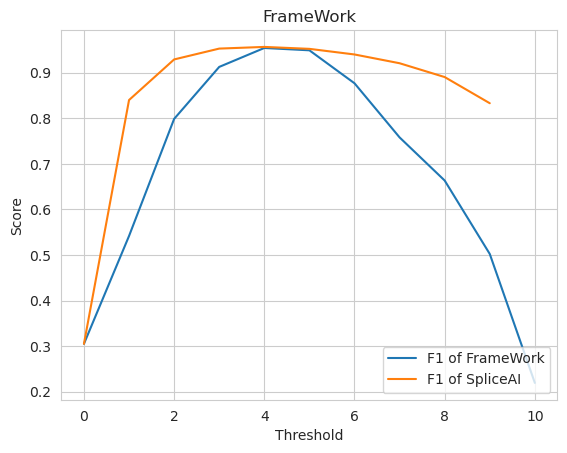

In [92]:
fw_threshold = 0
sa_threshold = 0.5

cm = confusion_matrix(data['LABEL'], data[f'FW_PRED_{fw_threshold}'])
cm2 = confusion_matrix(data['LABEL'], data[f'SpliceAI_PRED_{sa_threshold}'])

tn, fp, fn, tp = cm.flatten()
tn2, fp2, fn2, tp2 = cm2.flatten()

print(f"FW: tn={tn}, fp={fp}, fn={fn}, tp={tp}")
print(f"SA: tn={tn2}, fp={fp2}, fn={fn2}, tp={tp2}")
print("")

# fw_score: list = [accuracy_score(data['LABEL'], data[f'FW_PRED_{fw_threshold}']), precision_score(data['LABEL'], data[f'FW_PRED_{fw_threshold}']), recall_score(data['LABEL'], data[f'FW_PRED_{fw_threshold}']), f1_score(data['LABEL'], data[f'FW_PRED_{fw_threshold}'])]
# sa_score: list = [accuracy_score(data['LABEL'], data[f'SpliceAI_PRED_{sa_threshold}']), precision_score(data['LABEL'], data[f'SpliceAI_PRED_{sa_threshold}']), recall_score(data['LABEL'], data[f'SpliceAI_PRED_{sa_threshold}']), f1_score(data['LABEL'], data[f'SpliceAI_PRED_{sa_threshold}'])]

# summary = pd.DataFrame([fw_score, sa_score], columns=['Accuracy', 'Precision', 'Recall', 'F1'], index=['FrameWork', 'SpliceAI'])
# print(summary)

fw_accuracy: list = [accuracy_score(data['LABEL'], data[f'FW_PRED_{i}']) for i in range(0, 11)]
fw_precision: list = [precision_score(data['LABEL'], data[f'FW_PRED_{i}']) for i in range(0, 11)]
fw_recall: list = [recall_score(data['LABEL'], data[f'FW_PRED_{i}']) for i in range(0, 11)]
fw_f1: list = [f1_score(data['LABEL'], data[f'FW_PRED_{i}']) for i in range(0, 11)]

sa_accuracy: list = [accuracy_score(data['LABEL'], data[f'SpliceAI_PRED_{i/10}']) for i in range(0, 10)]
sa_precision: list = [precision_score(data['LABEL'], data[f'SpliceAI_PRED_{i/10}']) for i in range(0, 10)]
sa_recall: list = [recall_score(data['LABEL'], data[f'SpliceAI_PRED_{i/10}']) for i in range(0, 10)]
sa_f1: list = [f1_score(data['LABEL'], data[f'SpliceAI_PRED_{i/10}']) for i in range(0, 10)]


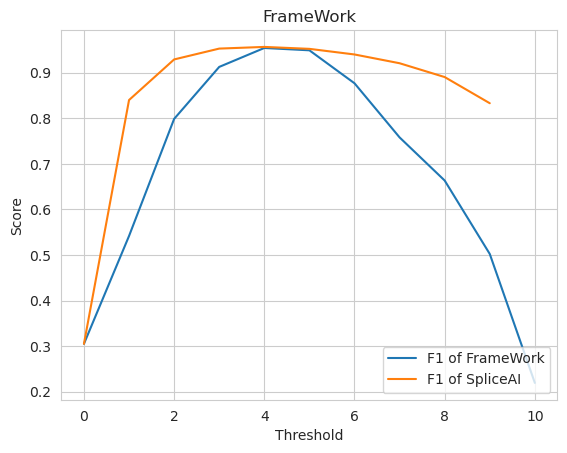

In [104]:

plt.figure()
# plt.plot(fw_accuracy, label='Accuracy of FrameWork')
# plt.plot(fw_precision, label='Precision of FrameWork')
# plt.plot(fw_recall, label='Recall of FrameWork')
plt.plot(fw_f1, label='F1 of FrameWork')

# plt.plot(sa_accuracy, label='Accuracy of SpliceAI')
# plt.plot(sa_precision, label='Precision of SpliceAI')
# plt.plot(sa_recall, label='Recall of SpliceAI')
plt.plot(sa_f1, label='F1 of SpliceAI')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('FrameWork')
plt.legend(loc="lower right")
plt.show()

